In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, InputLayer, Dense, Embedding, Normalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu

In [3]:
print(tf.__version__)

2.8.0


In [4]:
print(np.__version__)

1.21.6


In [5]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

In [6]:
raw_dataset = pd.read_csv(url, names=column_names,
                         na_values='?', comment='\t', 
                         sep=' ', skipinitialspace=True)
print(raw_dataset)

      MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
0    18.0          8         307.0       130.0  3504.0          12.0   
1    15.0          8         350.0       165.0  3693.0          11.5   
2    18.0          8         318.0       150.0  3436.0          11.0   
3    16.0          8         304.0       150.0  3433.0          12.0   
4    17.0          8         302.0       140.0  3449.0          10.5   
..    ...        ...           ...         ...     ...           ...   
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
0            70       1  
1            70       1  
2            70       1  
3            70       1  
4    

In [7]:
dataset = raw_dataset.copy()

In [8]:
pd.unique(dataset['Origin'])

array([1, 3, 2])

In [9]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [10]:
dataset = dataset.dropna()

In [11]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [12]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [13]:
dataset['Origin'].tail()

393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, dtype: object

In [14]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [15]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [16]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.sample(frac=0.2, random_state=0)

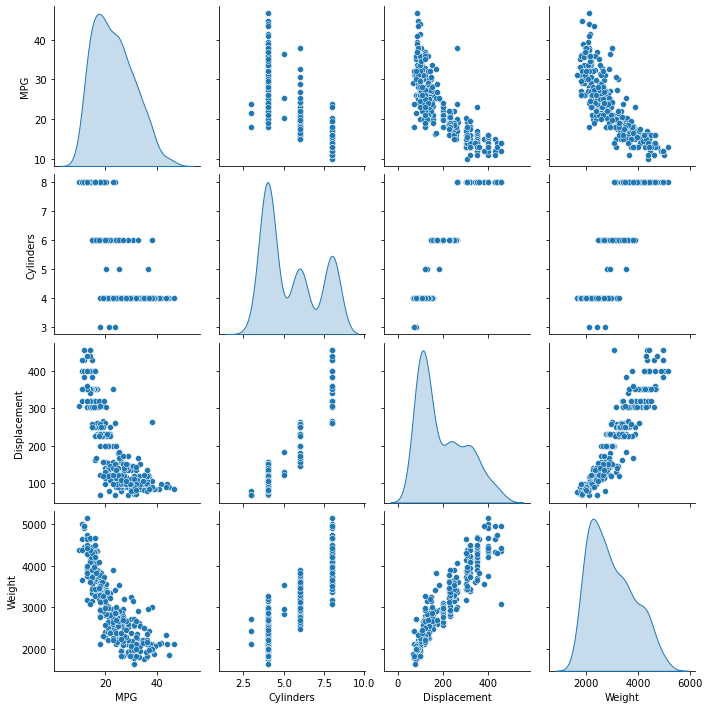

In [17]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [18]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [19]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [20]:
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [21]:
train_features.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


In [22]:
normalize = Normalization(axis=-1)

In [23]:
normalize.adapt(np.array(train_features))

Metal device set to: Apple M1


2022-06-25 21:44:58.225004: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-25 21:44:58.225134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-25 21:44:58.303066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-25 21:44:58.341336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:44:58.351762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [24]:
print(normalize.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [25]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example', first)
    print()
    print('Normalized: ', normalize(first).numpy())

First example [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized:  [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


In [26]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalize = Normalization(input_shape=[1, ], axis=None)
horsepower_normalize.adapt(horsepower)

2022-06-25 21:44:58.457730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:44:58.468084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [27]:
print(horsepower_normalize.mean.numpy())

[104.869]


In [28]:
horsepower_model = Sequential([
    horsepower_normalize,
    Dense(1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


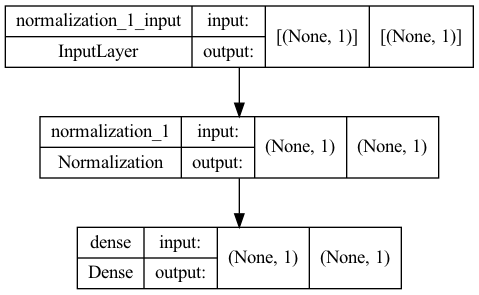

In [29]:
plot_model(horsepower_model, show_shapes=True)

In [30]:
horsepower_model.predict(horsepower[:10])

2022-06-25 21:44:58.722363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.728],
       [ 0.411],
       [-1.343],
       [ 1.02 ],
       [ 0.923],
       [ 0.362],
       [ 1.093],
       [ 0.923],
       [ 0.24 ],
       [ 0.411]], dtype=float32)

In [31]:
horsepower_model.compile(
    optimizer=Adam(learning_rate=0.1), 
    loss='mean_absolute_error'
)

In [32]:
%%time
history = horsepower_model.fit(horsepower, 
                                train_labels,
                                epochs=100,
                                validation_split=0.2, verbose=0)

2022-06-25 21:44:58.842055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:44:58.966867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 2.97 s, sys: 1.69 s, total: 4.66 s
Wall time: 3.65 s


In [33]:
hist = pd.DataFrame(history.history)

In [34]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epochs')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.ylim([1, 10])
    plt.grid(True)

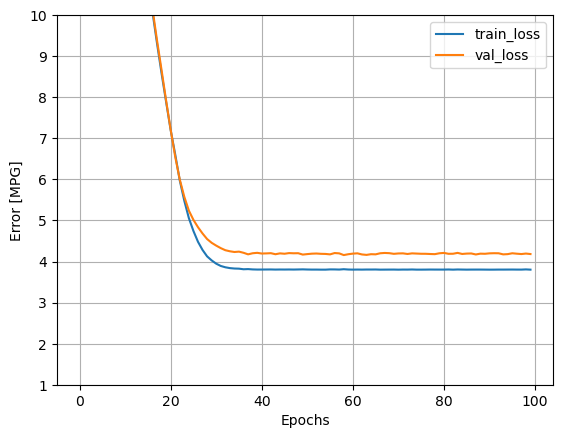

In [35]:
plot_loss(history)

In [36]:
test_results={}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 6ms/step - loss: 3.6830


2022-06-25 21:45:02.504963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [37]:
test_results

{'horsepower_model': 3.6830222606658936}

In [38]:
x = []
for i in range(251):
    x.append(i/1.0)

In [39]:
# x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

2022-06-25 21:45:02.575541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [40]:
def plot_horsepower(x, y):
    plt.figure(figsize=(7, 7))
    plt.scatter(train_features['Horsepower'], train_labels, label='Data')
    plt.plot(x, y, label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()
    plt.grid(True)

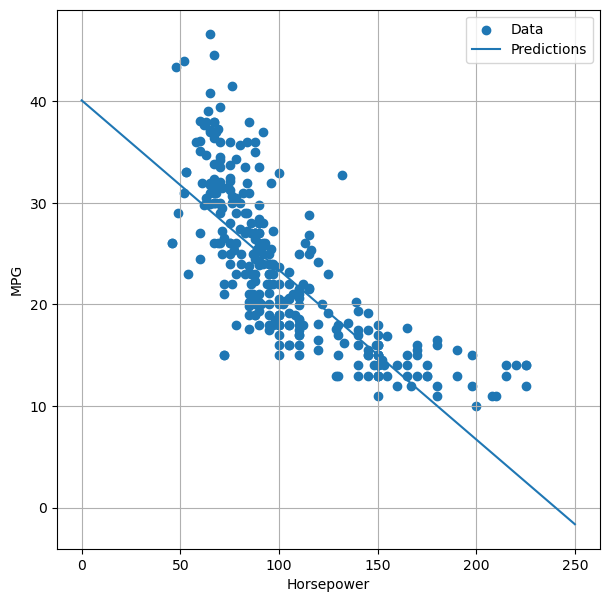

In [41]:
plot_horsepower(x, y)

In [42]:
linear_model = Sequential([normalize, 
                          Dense(1)])
linear_model.summary()
# plot_model(linear_model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 10        
                                                                 
Total params: 29
Trainable params: 10
Non-trainable params: 19
_________________________________________________________________


In [43]:
linear_model.predict(train_features[:10])

2022-06-25 21:45:02.718864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 0.543],
       [ 0.407],
       [-0.424],
       [ 0.188],
       [ 1.231],
       [ 0.265],
       [ 1.428],
       [-1.68 ],
       [ 0.308],
       [ 1.751]], dtype=float32)

In [44]:
lr = 0.1
linear_model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=lr))

In [45]:
%%time
history = linear_model.fit(
    train_features, 
    train_labels,
    epochs=100, verbose=0,
    validation_split=0.2)

2022-06-25 21:45:02.824108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:45:02.931724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.11 s, sys: 1.71 s, total: 4.82 s
Wall time: 3.67 s


In [46]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

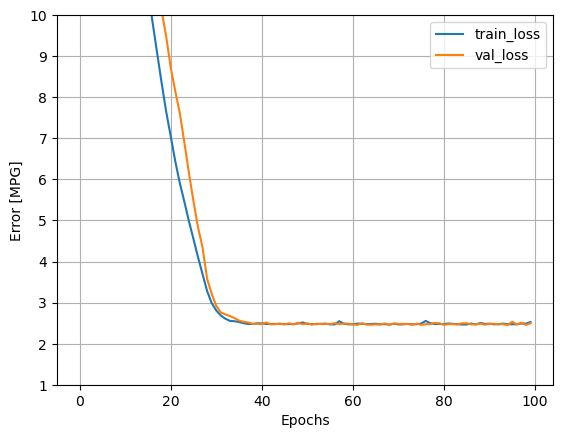

In [47]:
plot_loss(history)

In [48]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 6ms/step - loss: 2.1857


In [49]:
test_results

{'horsepower_model': 3.6830222606658936, 'linear_model': 2.1857452392578125}

In [50]:
def build_and_compile_model(norm, lr):
    model = Sequential ([norm, 
                         Dense(64, activation='relu'), 
                         Dense(64, activation='relu'),
                         Dense(1)])
    model.compile(loss='mean_absolute_error', 
                 optimizer=Adam(learning_rate=lr))
    
    return model

In [51]:
lr = 0.001
dnn_horsepower_model = build_and_compile_model(horsepower_normalize, lr)

In [52]:
%%time
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

2022-06-25 21:45:06.659214: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:45:06.818341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.79 s, sys: 1.83 s, total: 5.61 s
Wall time: 4.47 s


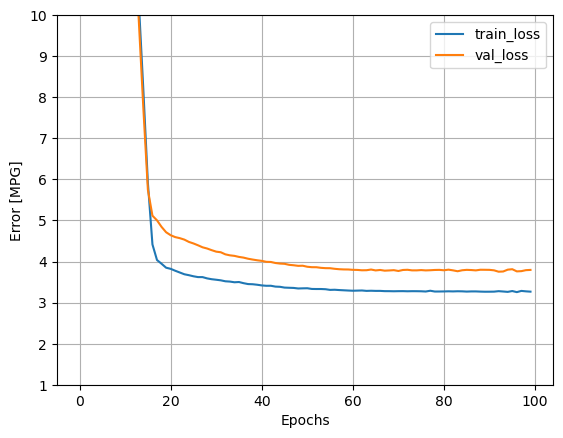

In [53]:
plot_loss(history)

In [54]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model(x)

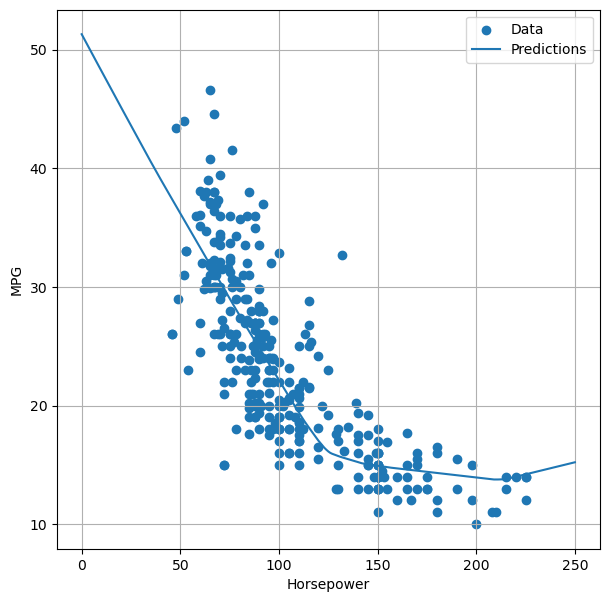

In [55]:
plot_horsepower(x, y)

In [56]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels)

3/3 [==============================] - 0s 10ms/step - loss: 3.0902


In [57]:
lr = 0.001
dnn_model = build_and_compile_model(normalize, lr)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


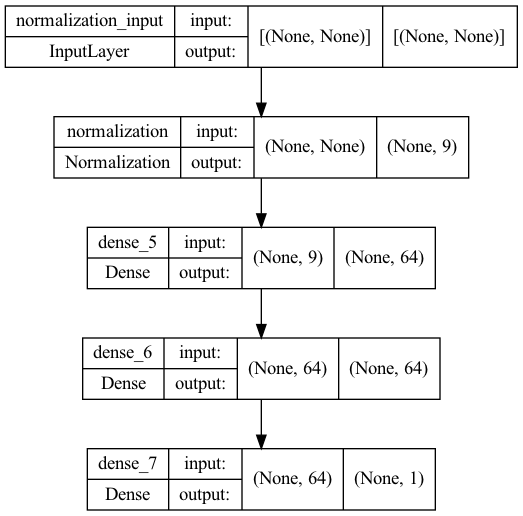

In [58]:
plot_model(dnn_model, show_shapes=True)

In [59]:
%%time
history = dnn_model.fit(
    train_features, train_labels, epochs=100, verbose=0, validation_split=0.2)

2022-06-25 21:45:11.520291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-25 21:45:11.661825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


CPU times: user 3.66 s, sys: 1.81 s, total: 5.47 s
Wall time: 4.49 s


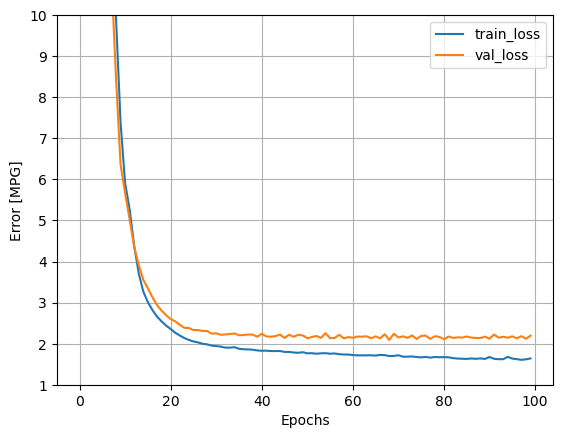

In [60]:
plot_loss(history)

In [61]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 9ms/step - loss: 1.4822


In [62]:
test_results

{'horsepower_model': 3.6830222606658936,
 'linear_model': 2.1857452392578125,
 'dnn_horsepower_model': 3.090219497680664,
 'dnn_model': 1.4822275638580322}

In [63]:
test_predictions = dnn_model.predict(test_features)

2022-06-25 21:45:16.048578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [64]:
test_predictions.shape

(78, 1)

In [65]:
test_predictions = tf.reshape(test_predictions, shape=[-1, ])

In [66]:
test_predictions

<tf.Tensor: shape=(78,), dtype=float32, numpy=
array([28.447, 24.147, 12.678, 36.843, 33.962, 20.837, 35.98 , 30.79 ,
       19.503, 24.36 , 27.93 , 14.668, 23.487, 12.109, 16.529, 33.809,
       21.906, 13.623, 23.79 , 25.287, 17.963, 15.644, 20.32 , 25.165,
       32.265, 13.451, 27.918, 25.065, 19.22 , 15.591, 18.947, 31.171,
       22.981, 28.187, 18.708, 27.635, 30.4  , 12.988, 15.736, 13.504,
       14.527, 36.181, 30.355, 14.886, 29.018, 15.171, 29.84 , 13.161,
       17.24 , 19.08 , 25.601, 14.988, 11.581, 21.883, 32.274, 30.181,
       24.776, 18.82 , 32.303, 23.107, 19.654, 26.481, 31.006, 13.27 ,
       25.574, 16.179, 14.172, 29.481, 21.446, 34.788, 34.293, 31.259,
       19.151, 16.344, 19.77 , 13.311, 25.366, 18.104], dtype=float32)>

In [67]:
test_predictions.shape

TensorShape([78])

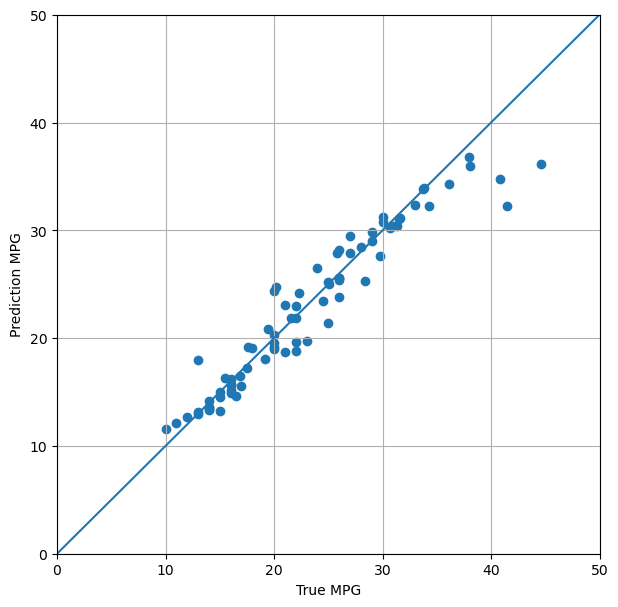

In [68]:
# a = plt.axes(aspect='equal')
plt.figure(figsize=(7, 7))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True MPG')
plt.ylabel('Prediction MPG')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.grid()
_ = plt.plot(lims, lims)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

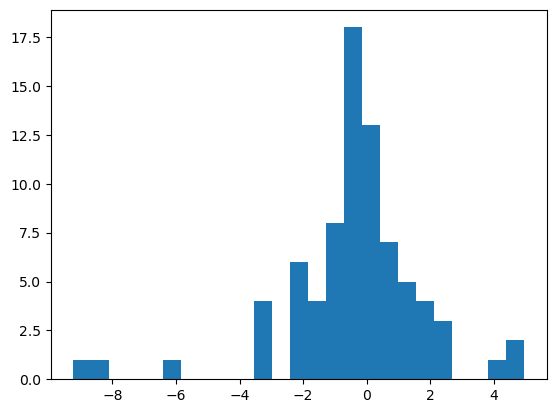

In [69]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel

In [70]:
dnn_model.save('dnn_model')

2022-06-25 21:45:16.508151: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: dnn_model/assets


In [71]:
reloaded = tf.keras.models.load_model('dnn_model')

In [72]:
test_results['reloaded'] = reloaded.evaluate(test_features, test_labels)

3/3 [==============================] - 0s 7ms/step - loss: 1.4822


2022-06-25 21:45:16.871023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [73]:
test_results

{'horsepower_model': 3.6830222606658936,
 'linear_model': 2.1857452392578125,
 'dnn_horsepower_model': 3.090219497680664,
 'dnn_model': 1.4822275638580322,
 'reloaded': 1.4822275638580322}

In [74]:
pd.DataFrame(test_results, index=['Mean abolute error [MPG]']).T

,Mean abolute error [MPG]
horsepower_model,3.683022
linear_model,2.185745
dnn_horsepower_model,3.090219
dnn_model,1.482228
reloaded,1.482228
